Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.
Submission File

For each ID in the test set, you must predict a probability for the TARGET variable. The file should contain a header and have the following format:

In [1]:
%time
import os
import numpy as np 
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn import neighbors
from sklearn import linear_model
import xgboost as xgb

import matplotlib.pyplot as plt

from sklearn import preprocessing


from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline

from sklearn.metrics import roc_auc_score


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


In [2]:
%time
#load data
test_data = pd.read_csv('../input/test.csv')
train_data = pd.read_csv('../input/train.csv')

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


In [3]:
# How data looks
train_data.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


In [4]:
# Write data to memory, to read data faster
#os.makedirs('tmp', exist_ok=True)
#train_data.to_feather('tmp/santanders-raw')

#for reading in memory data
#train_data = pd.read_feather('tmp/santanders-raw')

In [5]:
%time
# Any nulls?
(train_data.isnull().sum()).any() > 0

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


False

In [6]:
%time
# Drop columns what contains 0 only
dropable_cols = []
for i in train_data.columns:
    if (train_data[i] == 0).all():
        dropable_cols.append(i)
        
train_data.drop(dropable_cols, axis=1, inplace=True)
test_data.drop(dropable_cols, axis=1, inplace=True)
print("Train data shape: ",train_data.shape, "Test data shape: ", test_data.shape)


CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.54 µs
Train data shape:  (76020, 337) Test data shape:  (75818, 336)


In [7]:
%time
# accessing column throught index
columns = train_data.columns
train_data[columns[5]].head()

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 11.9 µs


0      0.0
1      0.0
2      0.0
3    195.0
4      0.0
Name: imp_op_var39_comer_ult3, dtype: float64

In [8]:
%time
# Removing dublicated columns
columns_to_drop = []
columns = train_data.columns
for i in range(len(columns) - 1):
    # assign and check column equality 
    column_to_check = train_data[columns[i]]
    for c in range(i+1, len(columns)):
        if np.array_equal(column_to_check, train_data[columns[c]].values):
            columns_to_drop.append(columns[c])
train_data.drop(columns_to_drop, axis=1, inplace=True)
test_data.drop(columns_to_drop, axis=1, inplace=True)
print("Train data shape: ",train_data.shape, "Test data shape: ", test_data.shape)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10.5 µs
Train data shape:  (76020, 308) Test data shape:  (75818, 307)


In [9]:
# What is in target column
train_data.TARGET.value_counts()
#if training is done only on negative rewiews(1), and if doest apply to neg model is true maybe it is better for model?

0    73012
1     3008
Name: TARGET, dtype: int64

In [10]:
%time
#Spliting to Train, test, valid
df_train = train_data[:64000] 
df_test = train_data[0:12000]
# Model will not see valid data set 
df_valid = train_data[64000:]
df_train.shape, df_test.shape, df_valid.shape

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 10.3 µs


((64000, 308), (12000, 308), (12020, 308))

In [11]:
%time
# Training data
X_train = df_train.drop(['ID', 'TARGET'], axis=1)
y_train = df_train.TARGET
# Test data
X_test = df_test.drop(['ID', 'TARGET'], axis=1)
y_test = df_test.TARGET
# Validation data
X_valid = df_valid.drop(['ID', 'TARGET'], axis=1)
y_valid = df_valid.TARGET
# submision data
data_for_sub = test_data.drop(['ID'], axis=1)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 11 µs


In [12]:
# Subset and full dataset score diffs
from sklearn import tree
from sklearn.model_selection import cross_validate as cv

score_metric = 'roc_auc'
scores = {}
def score_sub_model(model):
    
    return cv(model, X_train[:10000:2], y_train[:10000:2], cv=3, scoring=score_metric, return_train_score=False)

def score_full(model):
    return cv(model, X_train, y_train, cv=3, scoring=score_metric, return_train_score=False)

scores['extra_tree1'] = score_sub_model(ensemble.ExtraTreesClassifier(n_estimators=100))
scores['extra_tree2'] = score_full(ensemble.ExtraTreesClassifier(n_estimators=100))

'Sub set: ', scores['extra_tree1']['test_score'].mean(), 'Full set: ', scores['extra_tree2']['test_score'].mean()

('Sub set: ', 0.6538482711971433, 'Full set: ', 0.690624561877495)

In [13]:
# Select most apropiate model
# Xgboost, and Grad_Boost is best models
models = {'ExtraTree': ensemble.ExtraTreesClassifier(n_estimators=100), 
          'Forests': ensemble.RandomForestRegressor(n_estimators=100),
          'Ridge': linear_model.Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001),
          'Xgboost': xgb.XGBRegressor(n_estimators=100, max_depth=3),
         'Ada_Boost': ensemble.AdaBoostRegressor(),
         'Grad_Boost': ensemble.GradientBoostingRegressor()}

for i in models.keys():
    values = score_sub_model(models[i])
    print(i, values['test_score'].mean())

ExtraTree 0.6563785837141226
Forests 0.732040630658303


/home/rolandas/Programs/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.65538e-22): result may not be accurate.
  overwrite_a=True).T
/home/rolandas/Programs/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Ridge 0.7484214954145177
[21:51:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/rolandas/Programs/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:51:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/rolandas/Programs/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:51:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Xgboost 0.769824154898168
Ada_Boost 0.77460865555775
Grad_Boost 0.7848175782941998


In [14]:
# #PermutationImportance
# import eli5
# from eli5.sklearn import PermutationImportance

# clf = ensemble.GradientBoostingRegressor()
# clf.fit(X_train[:10000], y_train[:10000])

# perm = PermutationImportance(clf, random_state=1).fit(X_train[:10000], y_train[:10000])
# eli5.show_weights(perm, feature_names = X_train.columns.to_list())

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 11.7 µs


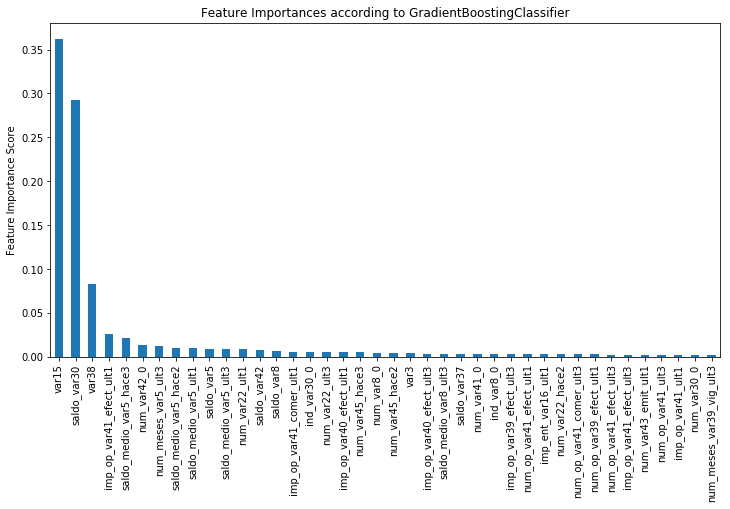

In [15]:
%time
## # Feature selection
# Classifier runs faster
clf = ensemble.GradientBoostingClassifier(n_estimators=100)
selector = clf.fit(X_train, y_train)

# plot most important features
feat_imp = pd.Series(clf.feature_importances_, index = X_train.columns.values).sort_values(ascending=False)
feat_imp[:40].plot(kind='bar', title='Feature Importances according to GradientBoostingClassifier', figsize=(12, 8))
plt.ylabel('Feature Importance Score')
plt.subplots_adjust(bottom=0.3)
plt.show()

In [16]:
# features to fit model
features = feat_imp[:40].index
print(features)

Index(['var15', 'saldo_var30', 'var38', 'imp_op_var41_efect_ult1',
       'saldo_medio_var5_hace3', 'num_var42_0', 'num_meses_var5_ult3',
       'saldo_medio_var5_hace2', 'saldo_medio_var5_ult1', 'saldo_var5',
       'saldo_medio_var5_ult3', 'num_var22_ult1', 'saldo_var42', 'saldo_var8',
       'imp_op_var41_comer_ult1', 'ind_var30_0', 'num_var22_ult3',
       'imp_op_var40_efect_ult1', 'num_var45_hace3', 'num_var8_0',
       'num_var45_hace2', 'var3', 'imp_op_var40_efect_ult3',
       'saldo_medio_var8_ult3', 'saldo_var37', 'num_var41_0', 'ind_var8_0',
       'imp_op_var39_efect_ult3', 'num_op_var41_efect_ult1',
       'imp_ent_var16_ult1', 'num_var22_hace2', 'num_op_var41_comer_ult3',
       'num_op_var39_efect_ult1', 'num_op_var41_efect_ult3',
       'imp_op_var41_efect_ult3', 'num_var43_emit_ult1', 'num_op_var41_ult3',
       'imp_op_var41_ult1', 'num_var30_0', 'num_meses_var39_vig_ult3'],
      dtype='object')


In [17]:
# mount new selected features
X_train = X_train[features]
X_test = X_test[features]
X_valid = X_valid[features]

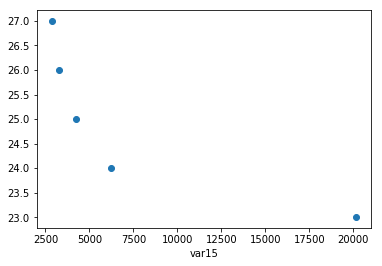

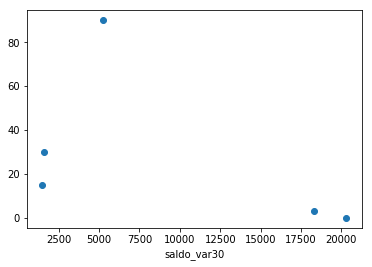

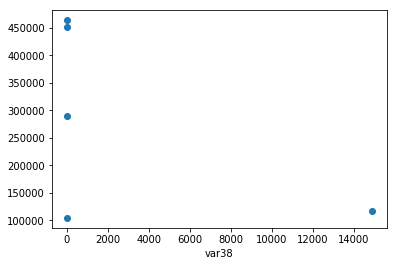

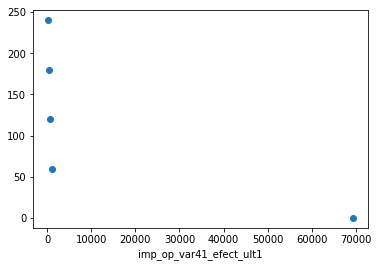

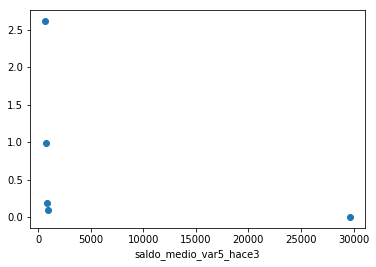

In [19]:
# plot first 5 most important features
for i in features[0:5]:
    #train_data[i].value_counts().mean()
    x = train_data[i].value_counts().head().index
    y = train_data[i].value_counts().head()
    
    plt.figure()
    plt.scatter(y, x)

    plt.xlabel(i)

In [35]:
%time
X_train = X_train[features]
X_test = X_test[features]
X_valid = X_valid[features]


from sklearn.model_selection import GridSearchCV
parameters = {'learning_rate': [0.1, 0.2, 0.3], 'n_estimators':[1,10,20,50,100], 'max_depth':[1,3,6], 'min_samples_split': [2, 3, 6]}

model = ensemble.GradientBoostingRegressor()
clf = GridSearchCV(model, parameters, cv=3, n_jobs=-1)

# 	learning_rate: 0.3
# 	max_depth: 3
# 	min_samples_split: 3
# 	n_estimators: 10

# create and fit a ridge regression model, testing random alpha values

clf.fit(X_train[:10000], y_train[:10000])


best_parameters=clf.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
#sorted(clf.cv_results_.keys())

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 11.2 µs
	learning_rate: 0.3
	max_depth: 3
	min_samples_split: 3
	n_estimators: 10


In [36]:
clf = ensemble.GradientBoostingRegressor(n_estimators=10, min_samples_split=3, max_depth=3, learning_rate=0.3)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
val_pred = clf.predict(X_valid)
roc_auc_score(y_test, preds), roc_auc_score(y_valid, val_pred)

(0.8372120831872452, 0.8216052204823238)

In [37]:
pros = clf.predict(data_for_sub[features])

In [38]:
# submission
sub = pd.DataFrame()
sub['ID'] = test_data['ID']
sub['target'] = pros
sub.to_csv('submission.csv',index=False)
# distribution of values
test = pd.read_csv('submission.csv')
test.head()

,ID,target
0,2,0.049804
1,5,0.049804
2,6,0.008194
3,7,0.016408
4,9,0.004411
